# Homework 12

https://scikit-learn.org/0.15/modules/scaling_strategies.html#incremental-learning

* Implement a mini batch functionality to train a regressor.
    - (Optional) If anyone want to do this in a pipeline can do this: https://koaning.github.io/tokenwiser/api/pipeline.html

* Save model, load the model again and test it on `X_test`

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [32]:
def test_df():
    df = pd.read_csv('https://raw.githubusercontent.com/msaricaumbc/DS_data/master/ds602/car_prices/car_prices.csv', low_memory=False)

    df = df.sample(5000, random_state=100).reset_index(drop=True)
    
    y = df['sellingprice']
    df.drop('sellingprice', axis=1, inplace=True)
    X = df
    
    return X,y

def partial_df():
    df = pd.read_csv('https://raw.githubusercontent.com/msaricaumbc/DS_data/master/ds602/car_prices/car_prices.csv', low_memory=False)
   
    while(True):
        yield df.sample(100).reset_index(drop=True)
        
gen = partial_df()

In [33]:
X_test, y_test = test_df()

In [34]:
# each time you call this you will get a new slice of the dataframe.
next(gen)

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,mmr,sellingprice,saledate
0,2012,Hyundai,Elantra,GLS,Sedan,automatic,kmhdh4ae9cu399575,va,3.1,29888.0,gray,gray,prestige financial services,10600,9700,Thu Dec 18 2014 09:20:00 GMT-0800 (PST)
1,2008,Kia,Amanti,Base,sedan,automatic,knald125585151198,mi,4.2,77375.0,gray,black,pra receivables management llc,6450,6900,Thu Jun 04 2015 02:30:00 GMT-0700 (PDT)
2,2012,Nissan,Rogue,S,suv,automatic,jn8as5mv9cw715639,wa,2.8,25430.0,gray,black,nissan-infiniti lt,13950,13600,Wed May 27 2015 05:30:00 GMT-0700 (PDT)
3,2014,Ford,Focus,SE,Sedan,automatic,1fadp3f23el147125,nc,3.6,15270.0,red,black,bb&t,12450,12600,Mon Feb 09 2015 01:30:00 GMT-0800 (PST)
4,2013,Ford,Focus,SE,sedan,NaN,1fadp3f25dl291791,pa,3.5,54474.0,white,black,dtg operations inc,8875,9100,Fri Jun 12 2015 02:00:00 GMT-0700 (PDT)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2013,Lexus,GS 350,Base,Sedan,automatic,jthbe1bl0d5002734,fl,3.4,32649.0,black,black,lexus financial services,32900,32000,Tue Feb 03 2015 01:30:00 GMT-0800 (PST)
96,2006,Chevrolet,TrailBlazer,LT,SUV,automatic,1gndt13s062136371,oh,3.7,124201.0,burgundy,black,credit acceptance corp/vrs/southfield,4325,6500,Thu Feb 26 2015 01:00:00 GMT-0800 (PST)
97,2008,Pontiac,G6,GT,Coupe,automatic,1g2zh17n384113604,il,3.5,45824.0,blue,black,santander consumer,6800,7600,Tue Jan 27 2015 02:00:00 GMT-0800 (PST)
98,2008,Chevrolet,Impala,SS,Sedan,automatic,2g1wd58c189286154,ny,3.4,119293.0,red,black,j zap llc,6500,7200,Thu Feb 26 2015 01:45:00 GMT-0800 (PST)


In [36]:
import pandas as pd
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
import joblib

regressor =SGDRegressor(fit_intercept=False,
                      alpha=0, 
                      eta0=0.01, 
                      power_t=.05, 
                      learning_rate='adaptive')

numerical_vars = ['year', 'odometer']
categorical_vars = ['make', 'model', 'trim', 'body', 'transmission', 'vin', 'state', 'condition', 'color', 'interior', 'seller', 'saledate']
num_pipeline = Pipeline([('impute_missing', SimpleImputer(strategy='median')),
                           ('standardize_num', StandardScaler())
                        ])
cat_pipeline = Pipeline([('impute_missing_cats', SimpleImputer(strategy='most_frequent')),
                          ('create_dummies_cats', OneHotEncoder(handle_unknown='ignore'))])
processing_pipeline = ColumnTransformer(transformers=[('proc_numeric', num_pipeline, numerical_vars),
                                                      ('create_dummies', cat_pipeline, categorical_vars)])

processing_pipeline.fit(X_test)

batch_size = 100
num_batches = 100

# Train the regressor using mini-batch gradient descent
for i in range(num_batches):
    batch = next(gen)
    X_batch = batch.drop('sellingprice', axis=1)
    y_batch = batch['sellingprice']
    
    X_batch_processed = processing_pipeline.transform(X_batch)
    
    X_batch_processed = np.nan_to_num(X_batch_processed)
    
    regressor.partial_fit(X_batch_processed, y_batch)
    

joblib.dump(regressor, 'regressor.pkl')



reloaded_regressor = joblib.load('regressor.pkl')

X_test_processed = processing_pipeline.transform(X_test)


y_pred = reloaded_regressor.predict(X_test_processed)


print(y_pred)


[12663.17272512 21670.95551961 16900.75118978 ... 19111.69365543
 17952.3478758  16791.62150419]


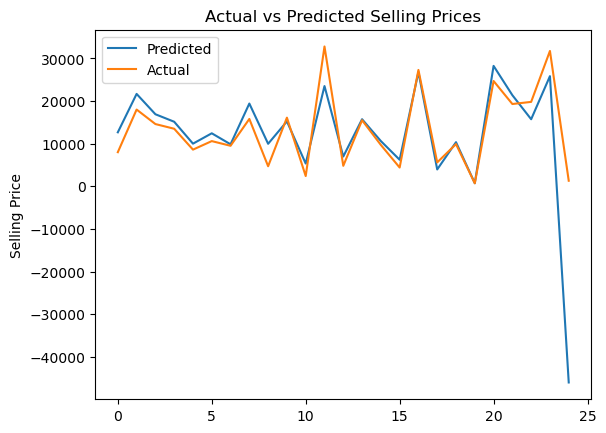

In [42]:
import matplotlib.pyplot as plt

plt.plot(y_pred[:25], label='Predicted')
plt.plot(y_test[:25], label='Actual')
plt.legend()
plt.title('Actual vs Predicted Selling Prices')
plt.ylabel('Selling Price')
plt.show()

In [37]:
from sklearn.metrics import mean_squared_error
import numpy as np


y_true = np.array(y_test)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print("RMSE on testing data:", rmse)


RMSE on testing data: 5025.113032439569


- High RMSE indicate model can be improved with Hyperparameter tuning

In [43]:
import numpy as np

batch_sizes = [10, 50, 100]
num_batches_list = [100, 500, 1000]

# Iterating over the different combinations of batch size and number of mini-batches
for batch_size in batch_sizes:
    for num_batches in num_batches_list:
        
        regressor =SGDRegressor(fit_intercept=False,
                                alpha=0, 
                                eta0=0.01, 
                                power_t=.05, 
                                learning_rate='adaptive')
        
        # Trainining the regressor using mini-batch gradient descent
        for i in range(num_batches):
            batch = next(gen)
            X_batch = batch.drop('sellingprice', axis=1)
            y_batch = batch['sellingprice']

            X_batch_processed = processing_pipeline.transform(X_batch)

            X_batch_processed = np.nan_to_num(X_batch_processed)

            regressor.partial_fit(X_batch_processed, y_batch)
        
        # Saveing the trained regressor to a file
        joblib.dump(regressor, f'regressor_{batch_size}_{num_batches}.pkl')

        # Loading the trained regressor from the file
        reloaded_regressor = joblib.load(f'regressor_{batch_size}_{num_batches}.pkl')

        # Processing the test data using the processing pipeline
        X_test_processed = processing_pipeline.transform(X_test)

        # Predicting the selling prices on the test set
        y_pred = reloaded_regressor.predict(X_test_processed)

        # Computing the root mean squared error of the predictions
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))

        # Print the batch size, number of mini-batches, and RMSE
        print(f'Batch size: {batch_size}, Num batches: {num_batches}, RMSE: {rmse}')


Batch size: 10, Num batches: 100, RMSE: 4955.221441139023
Batch size: 10, Num batches: 500, RMSE: 4195.370934778724
Batch size: 10, Num batches: 1000, RMSE: 3974.2569569931284
Batch size: 50, Num batches: 100, RMSE: 4961.776965406364
Batch size: 50, Num batches: 500, RMSE: 4481.4249599502145
Batch size: 50, Num batches: 1000, RMSE: 3942.0988492334936
Batch size: 100, Num batches: 100, RMSE: 5036.557566925024
Batch size: 100, Num batches: 500, RMSE: 4200.383651096383
Batch size: 100, Num batches: 1000, RMSE: 4022.013644161823


- From above we can observe as Number of batches increases there is a great decrease in RMSE hence we can use more batches for training
- Batch size of 50 and 1000 such batches resulted in least RMSE